# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%%time

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import math
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Wall time: 1min 2s


## 1.1 Reading Data

In [2]:
# using 35000 rows due to memory constraint

project_data = pd.read_csv('train_data.csv',nrows=35000)
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (35000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 1.2 preprocessing of `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [7]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [8]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...


In [9]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [10]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [13]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['preprocessed_essays'] = preprocessed_essays

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [00:30<00:00, 1144.56it/s]


In [17]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

#### Number of words in combined Essay

In [18]:
proj_essay_wrd_count = []

for word in project_data['preprocessed_essays']:
    proj_essay_wrd_count.append(len(word.split()))
project_data['proj_essay_wrd_count'] = proj_essay_wrd_count

project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,preprocessed_essays,proj_essay_wrd_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,my students english learners working english s...,161
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,our students arrive school eager learn they po...,109
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,Health_Sports,Health_Wellness TeamSports,"\r\n\""True champions aren't always the ones th...",true champions not always ones win guts by mia...,202


<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [19]:
# similarly you can preprocess the titles also
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year


In [20]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())
project_data['preprocessed_titles'] = preprocessed_titles

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [00:01<00:00, 25541.55it/s]


In [21]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,preprocessed_essays,proj_essay_wrd_count,preprocessed_titles
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,my students english learners working english s...,161,educational support english learners home
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,our students arrive school eager learn they po...,109,wanted projector hungry learners
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,...,NaN,"My students need shine guards, athletic socks,...",1,0,Health_Sports,Health_Wellness TeamSports,"\r\n\""True champions aren't always the ones th...",true champions not always ones win guts by mia...,202,soccer equipment awesome middle school students


#### Number of words in project title


In [22]:
proj_title_wrd_count = []

for word in project_data['preprocessed_titles']:
    proj_title_wrd_count.append(len(word.split()))
project_data['proj_title_wrd_count'] = proj_title_wrd_count
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,preprocessed_essays,proj_essay_wrd_count,preprocessed_titles,proj_title_wrd_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,my students english learners working english s...,161,educational support english learners home,5
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,our students arrive school eager learn they po...,109,wanted projector hungry learners,4
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,...,"My students need shine guards, athletic socks,...",1,0,Health_Sports,Health_Wellness TeamSports,"\r\n\""True champions aren't always the ones th...",true champions not always ones win guts by mia...,202,soccer equipment awesome middle school students,6


In [23]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

neg = []
pos = []
neu = []
compound = []

sid = SentimentIntensityAnalyzer()

for for_sentiment  in tqdm(project_data['preprocessed_essays']):

    neg.append(sid.polarity_scores(for_sentiment)['neg']) #Negative Sentiment score
    pos.append(sid.polarity_scores(for_sentiment)['pos']) #Positive Sentiment score
    neu.append(sid.polarity_scores(for_sentiment)['neu']) #Neutral Sentiment score
    compound.append(sid.polarity_scores(for_sentiment)['compound']) #Compound Sentiment score

# Creating new features    
project_data['Essay_neg_ss']      = neg
project_data['Essay_pos_ss']      = pos
project_data['Essay_neu_ss']      = neu
project_data['Essay_compound_ss'] = compound

project_data.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [06:22<00:00, 91.61it/s]


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,clean_subcategories,essay,preprocessed_essays,proj_essay_wrd_count,preprocessed_titles,proj_title_wrd_count,Essay_neg_ss,Essay_pos_ss,Essay_neu_ss,Essay_compound_ss
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,ESL Literacy,My students are English learners that are work...,my students english learners working english s...,161,educational support english learners home,5,0.012,0.144,0.844,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,Civics_Government TeamSports,Our students arrive to our school eager to lea...,our students arrive school eager learn they po...,109,wanted projector hungry learners,4,0.048,0.283,0.669,0.9856
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,...,Health_Wellness TeamSports,"\r\n\""True champions aren't always the ones th...",true champions not always ones win guts by mia...,202,soccer equipment awesome middle school students,6,0.122,0.219,0.659,0.9816


## 1.4.1 Project_grade preprocessing

In [24]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(" ", "_")
project_data['project_grade_category'].value_counts()

Grades_PreK-2    14199
Grades_3-5       11888
Grades_6-8        5415
Grades_9-12       3498
Name: project_grade_category, dtype: int64

### Preprocessing teacher_prefix

In [25]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace(".","")
project_data['teacher_prefix'].value_counts()

Mrs        18352
Ms         12530
Mr          3364
Teacher      752
Name: teacher_prefix, dtype: int64

## 1.5 Preparing data for models

In [26]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay',
       'preprocessed_essays', 'proj_essay_wrd_count', 'preprocessed_titles',
       'proj_title_wrd_count', 'Essay_neg_ss', 'Essay_pos_ss', 'Essay_neu_ss',
       'Essay_compound_ss'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### Split data into train,test and Cross validate


In [27]:
Y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)

In [28]:
X = project_data
X.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,clean_subcategories,essay,preprocessed_essays,proj_essay_wrd_count,preprocessed_titles,proj_title_wrd_count,Essay_neg_ss,Essay_pos_ss,Essay_neu_ss,Essay_compound_ss
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,ESL Literacy,My students are English learners that are work...,my students english learners working english s...,161,educational support english learners home,5,0.012,0.144,0.844,0.9694


In [29]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train)

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### One Hot Encode - Clean_Categories


In [30]:
# we use count vectorizer to convert the values into one hot encoded features

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_categories = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_categories.fit(X_train['clean_categories'].values)


categories_one_hot_train = vectorizer_categories.fit_transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer_categories.transform(X_test['clean_categories'].values)
categories_one_hot_cv = vectorizer_categories.transform(X_cv['clean_categories'].values)

print("After vectorizations")

print("Shape of Train data - one hot encoding ",categories_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",categories_one_hot_test.shape)
print("Shape of CV data - one hot encoding ",categories_one_hot_cv.shape)
print("="*100)
print(vectorizer_categories.get_feature_names())
print("="*100)

(15711, 25) (15711,)
(11550, 25) (11550,)
(7739, 25) (7739,)
After vectorizations
Shape of Train data - one hot encoding  (15711, 9)
Shape of Test data - one hot encoding  (11550, 9)
Shape of CV data - one hot encoding  (7739, 9)
['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


### One Hot Encode - Clean_Sub-Categories

In [31]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)


vectorizer_sub_cat = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_cat.fit(X_train['clean_subcategories'].values)

sub_cat_one_hot_train = vectorizer_sub_cat.fit_transform(X_train['clean_subcategories'].values)
sub_cat_one_hot_test = vectorizer_sub_cat.transform(X_test['clean_subcategories'].values)
sub_cat_one_hot_cv = vectorizer_sub_cat.transform(X_cv['clean_subcategories'].values)

print("After vectorizations")

print("Shape of Train data - one hot encoding ",sub_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding",sub_cat_one_hot_test.shape)
print("Shape of CV data - one hot encoding",sub_cat_one_hot_cv.shape)
print("="*100)

print(vectorizer_sub_cat.get_feature_names())
print("="*100)


(15711, 25) (15711,)
(11550, 25) (11550,)
(7739, 25) (7739,)
After vectorizations
Shape of Train data - one hot encoding  (15711, 30)
Shape of Test data - one hot encoding (11550, 30)
Shape of CV data - one hot encoding (7739, 30)
['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [32]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also

### One Hot Encode - School_States

In [33]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())

In [34]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [35]:
## we use count vectorizer to convert the values into one hot encoded features

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

vectorizer_school_state = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_school_state.fit(X_train['school_state'].values)

school_state_one_hot_train = vectorizer_school_state.fit_transform(X_train['school_state'].values)
school_state_one_hot_test = vectorizer_school_state.transform(X_test['school_state'].values)
school_state_one_hot_cv = vectorizer_school_state.transform(X_cv['school_state'].values)

print("After vectorizations")


print("Shape of Train data - one hot encoding",school_state_one_hot_train.shape)
print("Shape of Test data - one hot encoding",school_state_one_hot_test.shape)
print("Shape of CV data - one hot encoding",school_state_one_hot_cv.shape)
print("="*100)
print(vectorizer_school_state.get_feature_names())
print("="*100)

(15711, 25) (15711,)
(11550, 25) (11550,)
(7739, 25) (7739,)
After vectorizations
Shape of Train data - one hot encoding (15711, 51)
Shape of Test data - one hot encoding (11550, 51)
Shape of CV data - one hot encoding (7739, 51)
['VT', 'WY', 'ND', 'MT', 'RI', 'NH', 'SD', 'DE', 'AK', 'NE', 'ME', 'HI', 'WV', 'NM', 'DC', 'ID', 'IA', 'KS', 'AR', 'CO', 'MN', 'MS', 'OR', 'KY', 'MD', 'NV', 'AL', 'UT', 'CT', 'TN', 'WI', 'VA', 'NJ', 'AZ', 'OK', 'MA', 'LA', 'WA', 'MO', 'IN', 'OH', 'PA', 'MI', 'GA', 'SC', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']


### One Hot Encode - Project_Grade_Category

In [36]:
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [37]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [38]:
## we use count vectorizer to convert the values into one hot encoded features

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

vectorizer_project_grade_cat = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_project_grade_cat.fit(X_train['project_grade_category'].values)

project_grade_cat_one_hot_train = vectorizer_project_grade_cat.fit_transform(X_train['project_grade_category'].values)
project_grade_cat_one_hot_test = vectorizer_project_grade_cat.transform(X_test['project_grade_category'].values)
project_grade_cat_one_hot_cv = vectorizer_project_grade_cat.transform(X_cv['project_grade_category'].values)

print("After vectorizations")
print("="*100)
print("Shape of Train data - one hot encoding",project_grade_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding",project_grade_cat_one_hot_test.shape)
print("Shape of CV data - one hot encoding",project_grade_cat_one_hot_cv.shape)
print("="*100)
print(vectorizer_project_grade_cat.get_feature_names())

(15711, 25) (15711,)
(11550, 25) (11550,)
(7739, 25) (7739,)
After vectorizations
Shape of Train data - one hot encoding (15711, 4)
Shape of Test data - one hot encoding (11550, 4)
Shape of CV data - one hot encoding (7739, 4)
['Grades_9-12', 'Grades_6-8', 'Grades_3-5', 'Grades_PreK-2']


### One Hot Encode - Teacher_Prefix

In [39]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [40]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [41]:
vectorizer_teacher_prefix_cat = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_teacher_prefix_cat.fit(X_train['teacher_prefix'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

teacher_prefix_cat_one_hot_train = vectorizer_teacher_prefix_cat.fit_transform(X_train['teacher_prefix'].values.astype("U"))
teacher_prefix_cat_one_hot_test = vectorizer_teacher_prefix_cat.transform(X_test['teacher_prefix'].values.astype("U"))
teacher_prefix_cat_one_hot_cv = vectorizer_teacher_prefix_cat.transform(X_cv['teacher_prefix'].values.astype("U"))
print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",teacher_prefix_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",teacher_prefix_cat_one_hot_test.shape)
print("Shape of CV data - one hot encoding ",teacher_prefix_cat_one_hot_cv.shape)
print("="*100)


print(vectorizer_teacher_prefix_cat.get_feature_names())

(15711, 25) (15711,)
(11550, 25) (11550,)
(7739, 25) (7739,)
After vectorizations
Shape of Train data - one hot encoding (15711, 5)
Shape of Test data - one hot encoding  (11550, 5)
Shape of CV data - one hot encoding  (7739, 5)
['nan', 'Teacher', 'Mr', 'Ms', 'Mrs']


### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

#### BOW of eassys - Train/Test/CV Data

In [42]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_essay_bow = CountVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_essay_bow.fit(X_train['preprocessed_essays'])

# BOW for essays Train Data
essay_bow_train = vectorizer_essay_bow.fit_transform(X_train['preprocessed_essays'])
print("Shape of matrix for TRAIN data ",essay_bow_train.shape)

# BOW for essays Test Data
essay_bow_test = vectorizer_essay_bow.transform(X_test['preprocessed_essays'])
print("Shape of matrix for TEST data",essay_bow_test.shape)

# BOW for essays CV Data
essay_bow_cv = vectorizer_essay_bow.transform(X_cv['preprocessed_essays'])
print("Shape of matrix for CV data ",essay_bow_cv.shape)

Shape of matrix for TRAIN data  (15711, 5000)
Shape of matrix for TEST data (11550, 5000)
Shape of matrix for CV data  (7739, 5000)


#### BOW of Project Titles - Train/Test/CV Data

In [43]:
vectorizer_title_bow = CountVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_title_bow.fit(X_train['preprocessed_titles'])

# BOW for title Train Data
title_bow_train = vectorizer_title_bow.fit_transform(X_train['preprocessed_titles'])
print("Shape of matrix for TRAIN data ",title_bow_train.shape)

# BOW for title Test Data
title_bow_test = vectorizer_title_bow.transform(X_test['preprocessed_titles'])
print("Shape of matrix for TEST data",title_bow_test.shape)

# BOW for title CV Data
title_bow_cv = vectorizer_title_bow.transform(X_cv['preprocessed_titles'])
print("Shape of matrix for CV data ",title_bow_cv.shape)

Shape of matrix for TRAIN data  (15711, 394)
Shape of matrix for TEST data (11550, 394)
Shape of matrix for CV data  (7739, 394)


#### 1.5.2.2 TFIDF vectorizer for essay

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_essay_tfidf = TfidfVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_essay_tfidf.fit(X_train['preprocessed_essays'])

#tidf Train Data
essay_tfidf_train = vectorizer_essay_tfidf.fit_transform(X_train['preprocessed_essays'])
print("Shape of matrix for TRAIN data",essay_tfidf_train.shape)

#tidf Test Data
essay_tfidf_test = vectorizer_essay_tfidf.transform(X_test['preprocessed_essays'])
print("Shape of matrix for TEST data",essay_tfidf_test.shape)

#tidf CV Data
essay_tfidf_cv = vectorizer_essay_tfidf.transform(X_cv['preprocessed_essays'])
print("Shape of matrix for CV data",essay_tfidf_cv.shape)

Shape of matrix for TRAIN data (15711, 5000)
Shape of matrix for TEST data (11550, 5000)
Shape of matrix for CV data (7739, 5000)


#### TFIDF vectorizer for Title

In [45]:
vectorizer_title_tfidf = TfidfVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_title_tfidf.fit(X_train['preprocessed_titles'])

#tidf Train Data
title_tfidf_train = vectorizer_title_tfidf.fit_transform(X_train['preprocessed_titles'])
print("Shape of matrix for TRAIN data",title_tfidf_train.shape)

#tidf Test Data
title_tfidf_test = vectorizer_title_tfidf.transform(X_test['preprocessed_titles'])
print("Shape of matrix for TEST data",title_tfidf_test.shape)

#tidf CV Data
title_tfidf_cv = vectorizer_title_tfidf.transform(X_cv['preprocessed_titles'])
print("Shape of matrix for CV data",title_tfidf_cv.shape)

Shape of matrix for TRAIN data (15711, 394)
Shape of matrix for TEST data (11550, 394)
Shape of matrix for CV data (7739, 394)


#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [46]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [47]:
# average Word2Vec Function
# compute average word2vec for each review.
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v_vectors_func(sentance):
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector

#### Train/Test/CV  Data - Avg-W2V for essay

In [48]:
essay_avg_w2v_train = []
essay_avg_w2v_test  = []
essay_avg_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_essays']):
    essay_avg_w2v_train.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Train data
    
# Avg-w2v for Train data    
print("len(essay_avg_w2v_train):",len(essay_avg_w2v_train))
print("len(essay_avg_w2v_train[0])",len(essay_avg_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_essays']):
    essay_avg_w2v_test.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Test data

# Avg-w2v for Test data
print("len(essay_avg_w2v_test):",len(essay_avg_w2v_test))
print("len(essay_avg_w2v_test[0])",len(essay_avg_w2v_test[0]))


for sentence in tqdm(X_cv['preprocessed_essays']):    
    essay_avg_w2v_cv.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for CV data

# Avg-w2v for CV data
print("len(essay_avg_w2v_cv):",len(essay_avg_w2v_cv))
print("len(essay_avg_w2v_cv[0])",len(essay_avg_w2v_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15711/15711 [00:07<00:00, 2080.83it/s]


len(essay_avg_w2v_train): 15711
len(essay_avg_w2v_train[0]) 300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11550/11550 [00:05<00:00, 2102.63it/s]


len(essay_avg_w2v_test): 11550
len(essay_avg_w2v_test[0]) 300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7739/7739 [00:03<00:00, 2071.96it/s]


len(essay_avg_w2v_cv): 7739
len(essay_avg_w2v_cv[0]) 300


In [49]:
title_avg_w2v_train = []
title_avg_w2v_test  = []

for sentence in tqdm(X_train['preprocessed_titles']):
    title_avg_w2v_train.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Train data
    
# Avg-w2v for Train data    
print("len(title_avg_w2v_train):",len(title_avg_w2v_train))
print("len(title_avg_w2v_train[0])",len(title_avg_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_titles']):
    title_avg_w2v_test.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Test data

# Avg-w2v for Test data
print("len(title_avg_w2v_test):",len(title_avg_w2v_test))
print("len(title_avg_w2v_test[0])",len(title_avg_w2v_test[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15711/15711 [00:00<00:00, 34916.40it/s]


len(title_avg_w2v_train): 15711
len(title_avg_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11550/11550 [00:00<00:00, 32994.59it/s]


len(title_avg_w2v_test): 11550
len(title_avg_w2v_test[0]) 300


#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [50]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [51]:
# Compute  TFIDF weighted W2V for each sentence of the review.

def tf_idf_weight_func(sentence): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    return vector

#### Train/Test/CV Data - TFIDF weighted W2V for essay

In [52]:
essay_tfidf_w2v_train = []
essay_tfidf_w2v_test  = []
essay_tfidf_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_essays']):
    essay_tfidf_w2v_train.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Train data
print("len(essay_tfidf_w2v_train)",len(essay_tfidf_w2v_train))
print("len(essay_tfidf_w2v_train[0])",len(essay_tfidf_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_essays']):
    essay_tfidf_w2v_test.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Test data
print("len(essay_tfidf_w2v_test)",len(essay_tfidf_w2v_test))
print("len(essay_tfidf_w2v_test[0])",len(essay_tfidf_w2v_test[0]))

for sentence in tqdm(X_cv['preprocessed_essays']):
    essay_tfidf_w2v_cv.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for CV data
print("len(essay_tfidf_w2v_cv)",len(essay_tfidf_w2v_cv))
print("len(essay_tfidf_w2v_cv[0])",len(essay_tfidf_w2v_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15711/15711 [00:00<00:00, 27647.23it/s]


len(essay_tfidf_w2v_train) 15711
len(essay_tfidf_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11550/11550 [00:00<00:00, 25577.40it/s]


len(essay_tfidf_w2v_test) 11550
len(essay_tfidf_w2v_test[0]) 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7739/7739 [00:00<00:00, 20295.10it/s]


len(essay_tfidf_w2v_cv) 7739
len(essay_tfidf_w2v_cv[0]) 300


#### Train/Test/CV Data - Avg-W2V for essay


In [53]:
title_avg_w2v_train = []
title_avg_w2v_test  = []
title_avg_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_titles']):
    title_avg_w2v_train.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Train data
    
# Avg-w2v for Train data    
print("len(title_avg_w2v_train):",len(title_avg_w2v_train))
print("len(title_avg_w2v_train[0])",len(title_avg_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_titles']):
    title_avg_w2v_test.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Test data

# Avg-w2v for Test data
print("len(title_avg_w2v_test):",len(title_avg_w2v_test))
print("len(title_avg_w2v_test[0])",len(title_avg_w2v_test[0]))


for sentence in tqdm(X_cv['preprocessed_titles']):    
    title_avg_w2v_cv.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for CV data

# Avg-w2v for CV data
print("len(title_avg_w2v_cv):",len(title_avg_w2v_cv))
print("len(title_avg_w2v_cv[0])",len(title_avg_w2v_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15711/15711 [00:00<00:00, 36944.97it/s]


len(title_avg_w2v_train): 15711
len(title_avg_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11550/11550 [00:00<00:00, 34390.11it/s]


len(title_avg_w2v_test): 11550
len(title_avg_w2v_test[0]) 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7739/7739 [00:00<00:00, 30938.21it/s]


len(title_avg_w2v_cv): 7739
len(title_avg_w2v_cv[0]) 300


#### Train/Test/CV Data - TFIDF weighted W2V for Project Titles

In [54]:
title_tfidf_w2v_train  = []
title_tfidf_w2v_test  = []
title_tfidf_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_titles']):
    title_tfidf_w2v_train.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Train data
print("len(title_tfidf_w2v_train)",len(title_tfidf_w2v_train))
print("len(title_tfidf_w2v_train[0])",len(title_tfidf_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_titles']):
    title_tfidf_w2v_test.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Test data
print("len(title_tfidf_w2v_test)",len(title_tfidf_w2v_test))
print("len(title_tfidf_w2v_test[0])",len(title_tfidf_w2v_test[0]))

for sentence in tqdm(X_cv['preprocessed_titles']):
    title_tfidf_w2v_cv.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for CV data
print("len(title_tfidf_w2v_cv)",len(title_tfidf_w2v_cv))
print("len(title_tfidf_w2v_cv[0])",len(title_tfidf_w2v_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15711/15711 [00:00<00:00, 28571.24it/s]


len(title_tfidf_w2v_train) 15711
len(title_tfidf_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11550/11550 [00:00<00:00, 28179.20it/s]


len(title_tfidf_w2v_test) 11550
len(title_tfidf_w2v_test[0]) 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7739/7739 [00:00<00:00, 17536.76it/s]


len(title_tfidf_w2v_cv) 7739
len(title_tfidf_w2v_cv[0]) 300


### 1.5.3 Vectorizing Numerical features

In [55]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')
X_cv = pd.merge(X_cv, price_data, on='id', how='left')

In [56]:
from sklearn.preprocessing import Normalizer

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

price_data_train = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))

price_data_test = normalizer.transform(X_test['price'].values.reshape(-1,1))

price_data_cv = normalizer.transform(X_cv['price'].values.reshape(-1,1))

print("After vectorizations")
print("="*100)
print(price_data_train.shape, Y_train.shape)
print(price_data_test.shape, Y_test.shape)
print(price_data_cv.shape, Y_cv.shape)
print("="*100)

(15711, 27) (15711,)
(11550, 27) (11550,)
(7739, 27) (7739,)
After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)
(7739, 1) (7739,)


#### Vectorizing - Quantity Feature

In [57]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

quant_train = normalizer.fit_transform(X_train['quantity'].values.reshape(-1,1))
quant_cv = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
quant_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(quant_train.shape, Y_train.shape)
print(quant_cv.shape, Y_cv.shape)
print(quant_test.shape, Y_test.shape)
print("="*100)

(15711, 27) (15711,)
(11550, 27) (11550,)
(7739, 27) (7739,)
After vectorizations
(15711, 1) (15711,)
(7739, 1) (7739,)
(11550, 1) (11550,)


####  Vectorizing - teacher_number_of_previously_posted_projects 

In [58]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_no_projects_train = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_no_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_no_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(prev_no_projects_train.shape, Y_train.shape)
print(prev_no_projects_cv.shape, Y_cv.shape)
print(prev_no_projects_test.shape, Y_test.shape)
print("="*100)

(15711, 27) (15711,)
(11550, 27) (11550,)
(7739, 27) (7739,)
After vectorizations
(15711, 1) (15711,)
(7739, 1) (7739,)
(11550, 1) (11550,)


####  Vectorizing - Word count title

In [59]:
normalizer = Normalizer()

normalizer.fit(X_train['proj_title_wrd_count'].values.reshape(-1,1))

title_cnt_train = normalizer.fit_transform(X_train['proj_title_wrd_count'].values.reshape(-1,1))
title_cnt_test = normalizer.transform(X_test['proj_title_wrd_count'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(title_cnt_train.shape, Y_train.shape)
print(title_cnt_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)


####  Vectorizing - Essay count title

In [86]:
normalizer = Normalizer()

normalizer.fit(X_train['proj_essay_wrd_count'].values.reshape(-1,1))

essay_cnt_train = normalizer.fit_transform(X_train['proj_essay_wrd_count'].values.reshape(-1,1))
essay_cnt_test = normalizer.transform(X_test['proj_essay_wrd_count'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(title_cnt_train.shape, Y_train.shape)
print(title_cnt_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)


####  Vectorizing - Sentiment Score negative

In [60]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_neg_ss'].values.reshape(-1,1))

essay_neg_train = normalizer.fit_transform(X_train['Essay_neg_ss'].values.reshape(-1,1))
essay_neg_test = normalizer.transform(X_test['Essay_neg_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_neg_train.shape, Y_train.shape)
print(essay_neg_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)


####  Vectorizing - Sentiment Score positive

In [61]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_pos_ss'].values.reshape(-1,1))

essay_pos_train = normalizer.fit_transform(X_train['Essay_pos_ss'].values.reshape(-1,1))
essay_pos_test = normalizer.transform(X_test['Essay_pos_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_pos_train.shape, Y_train.shape)
print(essay_pos_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)


####  Vectorizing - Sentiment Score neutral

In [62]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_neu_ss'].values.reshape(-1,1))

essay_neu_train = normalizer.fit_transform(X_train['Essay_neu_ss'].values.reshape(-1,1))
essay_neu_test = normalizer.transform(X_test['Essay_neu_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_neu_train.shape, Y_train.shape)
print(essay_neu_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)


####  Vectorizing - Sentiment Score compound

In [63]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_compound_ss'].values.reshape(-1,1))

essay_compound_train = normalizer.fit_transform(X_train['Essay_compound_ss'].values.reshape(-1,1))
essay_compund_test = normalizer.transform(X_test['Essay_compound_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_compound_train.shape, Y_train.shape)
print(essay_compund_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(15711, 1) (15711,)
(11550, 1) (11550,)


# Assignment 5: Logistic Regression

<ol>
    <li><strong>[Task-1] Logistic Regression(either SGDClassifier with log loss, or LogisticRegression) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (`BOW with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (`TFIDF with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply Logistic Regression on the below feature set <font color='red'> Set 5 </font> by finding the best hyper parameter as suggested in step 2 and step 3.</strong>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
            </ul>
        And apply the Logistic regression on these features by finding the best hyper paramter as suggested in step 2 and step 3 <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Logistic Regression </h1>

<h2>2.4 Appling Logistic Regression on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Logistic Regression on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

###   Applying Logistic Regression on <font color='red'> BOW</font>

In [64]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    


In [65]:
from scipy.sparse import hstack

X_train_merge = hstack((categories_one_hot_train, sub_cat_one_hot_train, school_state_one_hot_train, project_grade_cat_one_hot_train, teacher_prefix_cat_one_hot_train, price_data_train, quant_train, prev_no_projects_train,title_bow_train, essay_bow_train)).tocsr()
X_test_merge = hstack((categories_one_hot_test, sub_cat_one_hot_test, school_state_one_hot_test, project_grade_cat_one_hot_test, teacher_prefix_cat_one_hot_test, price_data_test, quant_test, prev_no_projects_test,title_bow_test, essay_bow_test)).tocsr()

### Best hyper prameter using the ROC/AUC higest value and K-fold cross validation

In [66]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

log of 0.5  =  0.3010299956639812
log of 0.1  =  1.0
log of 0.05  =  1.3010299956639813
log of 0.01  =  2.0
log of 0.005  =  2.3010299956639813


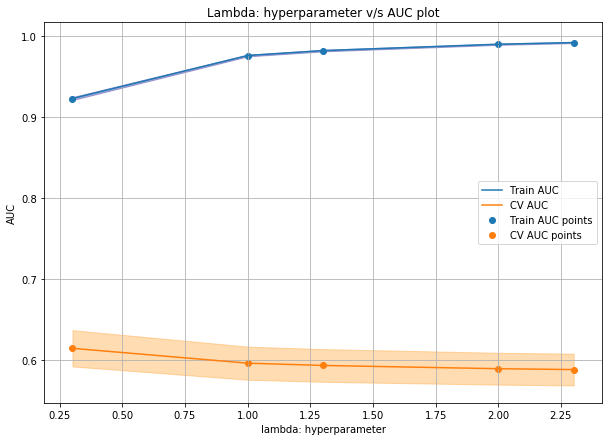

Best Score:  0.6140628784876305
Best Params:  {'C': 0.3010299956639812}


In [67]:
#https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',class_weight='balanced')

parameters = {'C':[0.5, 0.1, 0.05, 0.01, 0.005]}

temp
for key,values in parameters.items():
     for v in values:
            temp=abs(math.log10(v))
            
            print('log of',v," = ",(temp))

parameters = {'C':[abs(math.log10(0.5)),abs(math.log10(0.1)),abs(math.log10(0.05)),
                   abs(math.log10(0.01)),abs(math.log10(0.005))]}


clf = GridSearchCV(lr, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.figure(figsize=(10,7))

plt.plot(parameters['C'], train_auc, label='Train AUC')
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

print('Best Score: ', clf.best_score_)
print('Best Params: ', clf.best_params_)

In [68]:
best_C = 0.5 #log of 0.5  =  0.3010299956639812

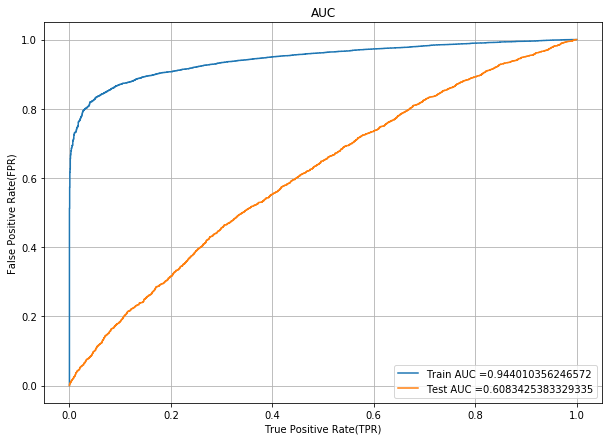

In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C = best_C,penalty='l1',class_weight='balanced') #Multinominal Naive Bayes.
lr.fit(X_train_merge, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict_proba(X_train_merge)[:,1]    
y_test_pred = lr.predict_proba(X_test_merge)[:,1]

plt.figure(figsize=(10,7))


train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

#### Confusion Matrix


In [70]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [71]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.244
[[ 1209  1210]
 [  508 12784]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.22
[[ 308 1470]
 [ 868 8904]]


Train confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.244


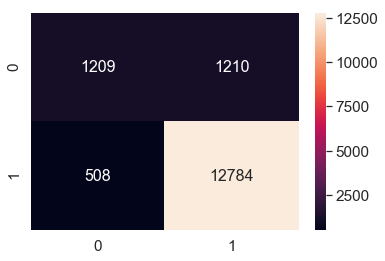

In [72]:
print("Train confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

Test confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.22


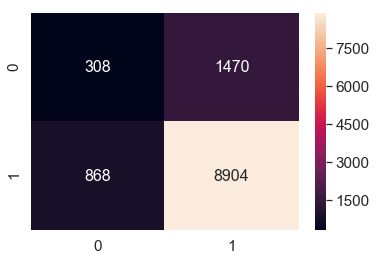

In [73]:
print("Test confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

###   Applying Logistic Regression on <font color='red'> TFIDF</font>

In [74]:
from scipy.sparse import hstack

X_train_merge = hstack((categories_one_hot_train, sub_cat_one_hot_train, school_state_one_hot_train, project_grade_cat_one_hot_train, teacher_prefix_cat_one_hot_train, price_data_train, quant_train, prev_no_projects_train,title_tfidf_train, essay_tfidf_train)).tocsr()
X_test_merge = hstack((categories_one_hot_test, sub_cat_one_hot_test, school_state_one_hot_test, project_grade_cat_one_hot_test, teacher_prefix_cat_one_hot_test, price_data_test, quant_test, prev_no_projects_test,title_tfidf_test, essay_tfidf_test)).tocsr()

log of 0.5  =  0.3010299956639812
log of 0.1  =  1.0
log of 0.05  =  1.3010299956639813
log of 0.01  =  2.0
log of 0.005  =  2.3010299956639813


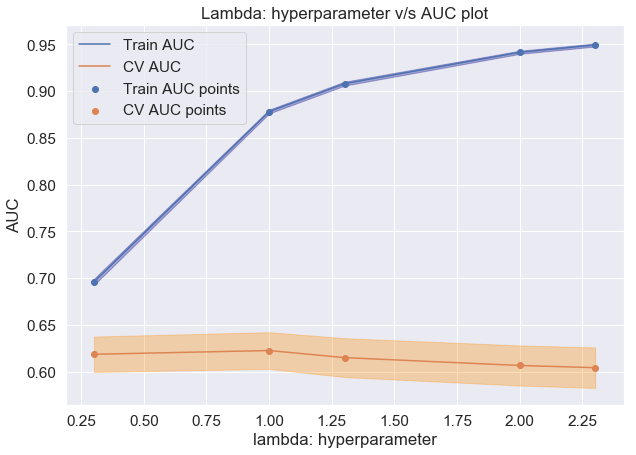

Best Score:  0.6225916732693123
Best Params:  {'C': 1.0}


In [75]:
#https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',class_weight='balanced')

parameters = {'C':[0.5, 0.1, 0.05, 0.01, 0.005]}

temp
for key,values in parameters.items():
     for v in values:
            temp=abs(math.log10(v))
            
            print('log of',v," = ",(temp))

parameters = {'C':[abs(math.log10(0.5)),abs(math.log10(0.1)),abs(math.log10(0.05)),
                   abs(math.log10(0.01)),abs(math.log10(0.005))]}


clf = GridSearchCV(lr, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.figure(figsize=(10,7))

plt.plot(parameters['C'], train_auc, label='Train AUC')
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

print('Best Score: ', clf.best_score_)
print('Best Params: ', clf.best_params_)

In [76]:
best_C = 0.1 #log of 0.1  =  1.0

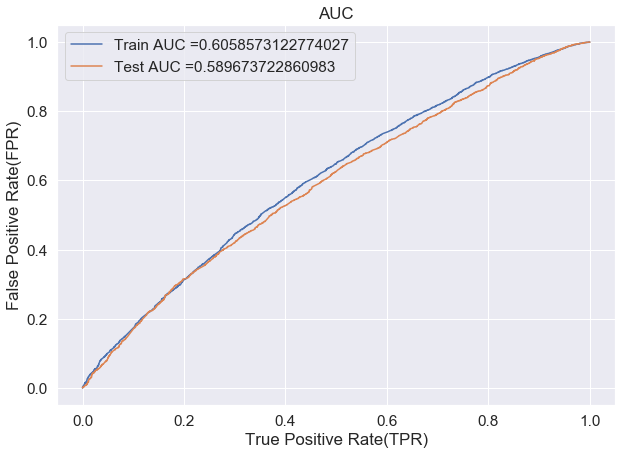

In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C = best_C,penalty='l1',class_weight='balanced') #Multinominal Naive Bayes.
lr.fit(X_train_merge, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

plt.figure(figsize=(10,7))

y_train_pred = lr.predict_proba(X_train_merge)[:,1]       
y_test_pred = lr.predict_proba(X_test_merge)[:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

#### Confusion Matrix


In [78]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [79]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.494
[[1210 1209]
 [4683 8609]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.512
[[1094  684]
 [4746 5026]]


Train confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.494


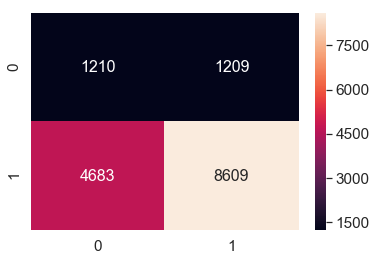

In [80]:
print("Train confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

Test confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.512


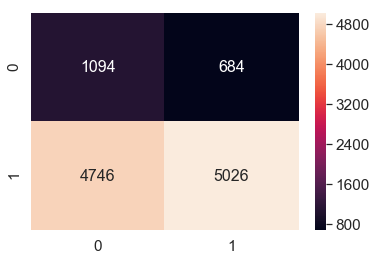

In [81]:
print("Test confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

###   Applying Logistic Regression on <font color='red'> AVG-W2V</font>

In [67]:
from scipy.sparse import hstack

X_train_merge = hstack((categories_one_hot_train, sub_cat_one_hot_train, school_state_one_hot_train, project_grade_cat_one_hot_train, teacher_prefix_cat_one_hot_train, price_data_train, quant_train, prev_no_projects_train,title_avg_w2v_train, essay_avg_w2v_train)).tocsr()
X_test_merge = hstack((categories_one_hot_test, sub_cat_one_hot_test, school_state_one_hot_test, project_grade_cat_one_hot_test, teacher_prefix_cat_one_hot_test, price_data_test, quant_test, prev_no_projects_test,title_avg_w2v_test, essay_avg_w2v_test)).tocsr()

log of 0.5  =  0.3010299956639812
log of 0.1  =  1.0
log of 0.05  =  1.3010299956639813
log of 0.01  =  2.0
log of 0.005  =  2.3010299956639813


C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



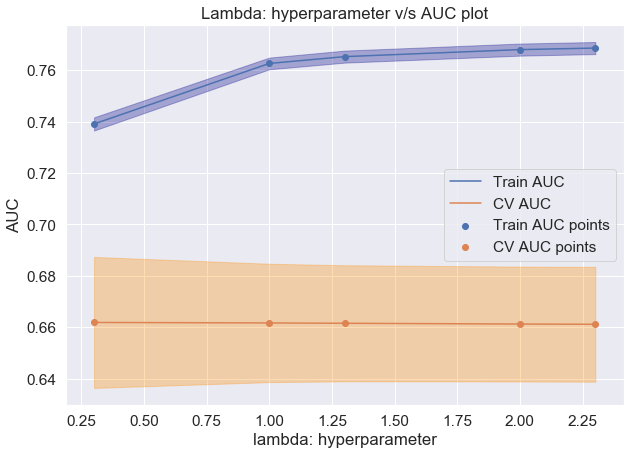

Best Score:  0.6618603477219153
Best Params:  {'C': 0.3010299956639812}


In [83]:
#https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',class_weight='balanced')

parameters = {'C':[0.5, 0.1, 0.05, 0.01, 0.005]}

temp
for key,values in parameters.items():
     for v in values:
            temp=abs(math.log10(v))
            
            print('log of',v," = ",(temp))

parameters = {'C':[abs(math.log10(0.5)),abs(math.log10(0.1)),abs(math.log10(0.05)),
                   abs(math.log10(0.01)),abs(math.log10(0.005))]}


clf = GridSearchCV(lr, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.figure(figsize=(10,7))

plt.plot(parameters['C'], train_auc, label='Train AUC')
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

print('Best Score: ', clf.best_score_)
print('Best Params: ', clf.best_params_)

In [68]:
best_C = 0.5 #log of 0.5  =  0.3010299956639812

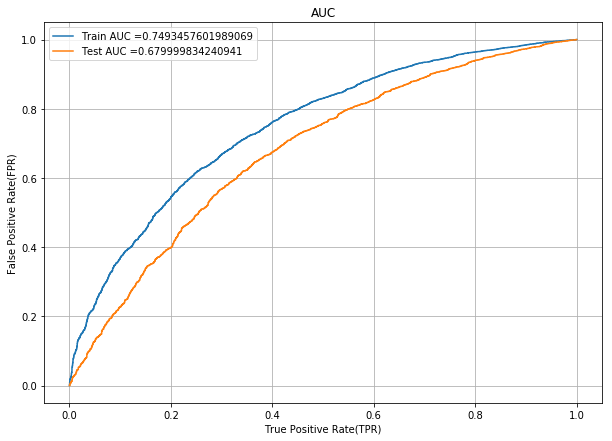

In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(C = best_C,penalty='l1',class_weight='balanced') #Multinominal Naive Bayes.
lr.fit(X_train_merge, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

plt.figure(figsize=(10,7))


y_train_pred = lr.predict_proba(X_train_merge)[:,1]       
y_test_pred = lr.predict_proba(X_test_merge)[:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

#### Confusion Matrix


In [70]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [71]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.406
[[ 1210  1209]
 [ 2263 11029]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.474
[[ 998  780]
 [2791 6981]]


Train confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.406


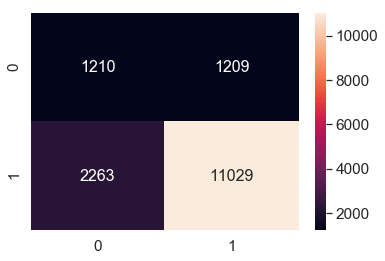

In [72]:
print("Train confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

Test confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.474


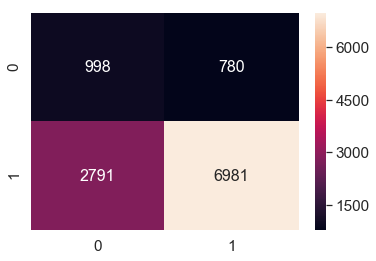

In [73]:
print("Test confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

###   Applying Logistic Regression on <font color='red'> TFIDF-W2V</font>

In [74]:
from scipy.sparse import hstack

X_train_merge = hstack((categories_one_hot_train, sub_cat_one_hot_train, school_state_one_hot_train, project_grade_cat_one_hot_train, teacher_prefix_cat_one_hot_train, price_data_train, quant_train, prev_no_projects_train,title_tfidf_w2v_train, essay_tfidf_w2v_train)).tocsr()
X_test_merge = hstack((categories_one_hot_test, sub_cat_one_hot_test, school_state_one_hot_test, project_grade_cat_one_hot_test, teacher_prefix_cat_one_hot_test, price_data_test, quant_test, prev_no_projects_test,title_tfidf_w2v_test, essay_tfidf_w2v_test)).tocsr()

log of 0.5  =  0.3010299956639812
log of 0.1  =  1.0
log of 0.05  =  1.3010299956639813
log of 0.01  =  2.0
log of 0.005  =  2.3010299956639813


C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: Co

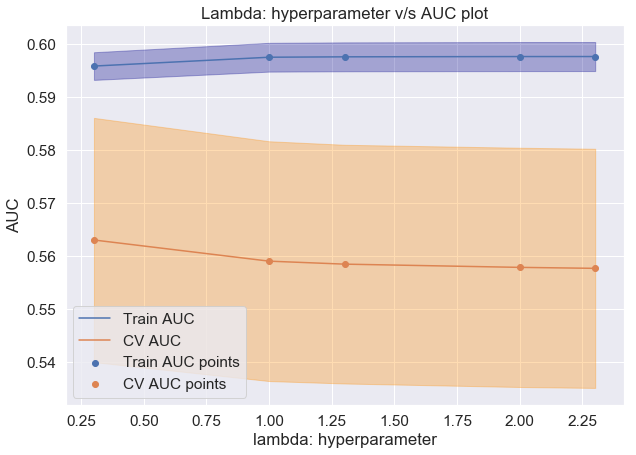

Best Score:  0.5630673295784446
Best Params:  {'C': 0.3010299956639812}


In [75]:
#https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',class_weight='balanced')

parameters = {'C':[0.5, 0.1, 0.05, 0.01, 0.005]}

temp
for key,values in parameters.items():
     for v in values:
            temp=abs(math.log10(v))
            
            print('log of',v," = ",(temp))

parameters = {'C':[abs(math.log10(0.5)),abs(math.log10(0.1)),abs(math.log10(0.05)),
                   abs(math.log10(0.01)),abs(math.log10(0.005))]}

clf = GridSearchCV(lr, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.figure(figsize=(10,7))

plt.plot(parameters['C'], train_auc, label='Train AUC')
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

print('Best Score: ', clf.best_score_)
print('Best Params: ', clf.best_params_)

In [78]:
best_C = 0.5 #log of 0.5  =  0.3010299956639812


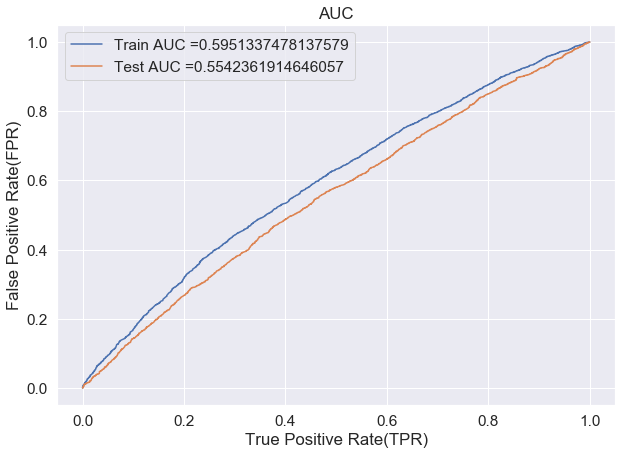

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C = best_C,penalty='l1',class_weight='balanced') #Multinominal Naive Bayes.
lr.fit(X_train_merge, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict_proba(X_train_merge)[:,1]       
y_test_pred = lr.predict_proba(X_test_merge)[:,1]   

plt.figure(figsize=(10,7))


train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

In [80]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [81]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.486
[[1210 1209]
 [4889 8403]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.515
[[1051  727]
 [4924 4848]]


Train confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.486


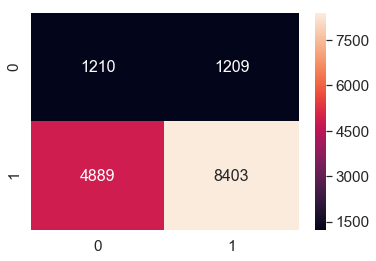

In [82]:
print("Train confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

Test confusion matrix-Heat map
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.515


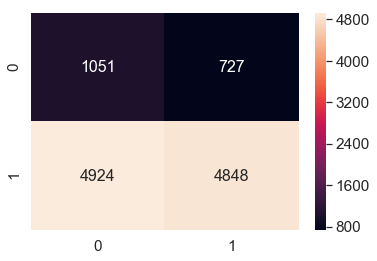

In [83]:
print("Test confusion matrix-Heat map")
print("="*100)
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
print("="*100)

<h2>2.5 Logistic Regression with added Features `Set 5` </h2>

In [84]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [87]:
from scipy.sparse import hstack

X_train_merge = hstack((categories_one_hot_train, sub_cat_one_hot_train, school_state_one_hot_train, project_grade_cat_one_hot_train, teacher_prefix_cat_one_hot_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train,essay_cnt_train,essay_neg_train,essay_pos_train,essay_neu_train,essay_compound_train)).tocsr()
X_test_merge = hstack((categories_one_hot_test, sub_cat_one_hot_test, school_state_one_hot_test, project_grade_cat_one_hot_test, teacher_prefix_cat_one_hot_test, price_data_test, quant_test, prev_no_projects_test,title_cnt_test,essay_cnt_test,essay_neg_test,essay_pos_test,essay_neu_test,essay_compund_test)).tocsr()

log of 0.5  =  0.3010299956639812
log of 0.1  =  1.0
log of 0.05  =  1.3010299956639813
log of 0.01  =  2.0
log of 0.005  =  2.3010299956639813


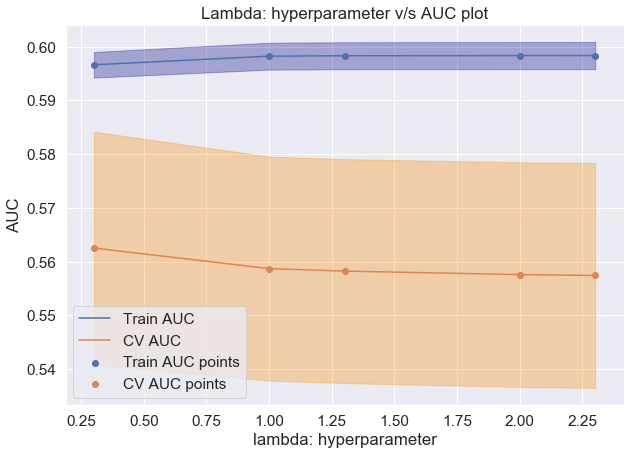

Best Score:  0.5625243766963299
Best Params:  {'C': 0.3010299956639812}


In [88]:
#https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',class_weight='balanced')

parameters = {'C':[0.5, 0.1, 0.05, 0.01, 0.005]}

temp
for key,values in parameters.items():
     for v in values:
            temp=abs(math.log10(v))
            
            print('log of',v," = ",(temp))

parameters = {'C':[abs(math.log10(0.5)),abs(math.log10(0.1)),abs(math.log10(0.05)),
                   abs(math.log10(0.01)),abs(math.log10(0.005))]}
clf = GridSearchCV(lr, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.figure(figsize=(10,7))

plt.plot(parameters['C'], train_auc, label='Train AUC')
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

#Summary of the grid search
print('Best Score: ', clf.best_score_)
print('Best Params: ', clf.best_params_)

In [89]:
best_C = 0.5 #log of 0.5  =  0.3010299956639812


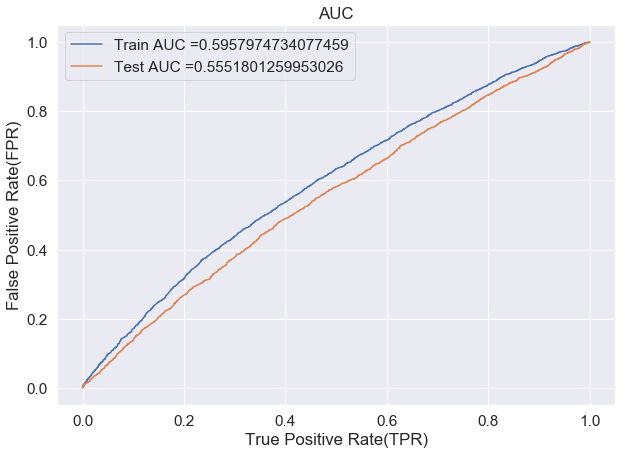

In [90]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C = best_C,penalty='l1',class_weight='balanced') #Multinominal Naive Bayes.
lr.fit(X_train_merge, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict_proba(X_train_merge)[:,1]       
y_test_pred = lr.predict_proba(X_test_merge)[:,1]   

plt.figure(figsize=(10,7))


train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

In [91]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [92]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.486
[[1210 1209]
 [4873 8419]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.517
[[1090  688]
 [5091 4681]]


the maximum value of tpr*(1-fpr) 0.24999995727635754 for threshold 0.486


Text(26.5, 0.5, 'Actual Label')

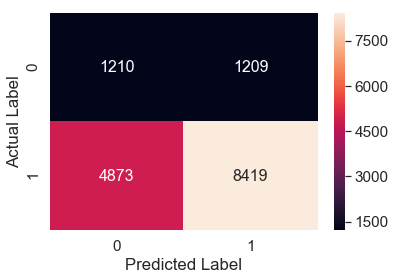

In [93]:
conf_matr_df_tfidf_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

the maximum value of tpr*(1-fpr) 0.25 for threshold 0.517


Text(26.5, 0.5, 'Actual Label')

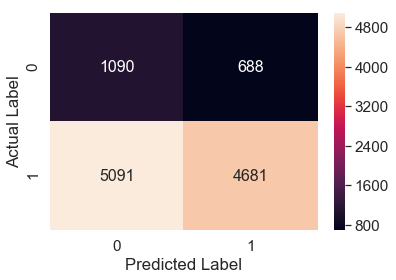

In [94]:
conf_matr_df_tfidf_test = pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

<h1>3. Conclusion</h1>

In [95]:
# Please compare all your models using Prettytable library

In [97]:
from prettytable import PrettyTable

x_pretty_table = PrettyTable()
x_pretty_table.field_names = ["Model Type","Vectorizer", "Hyper Parameter - C","Train-AUC","Test-AUC"]

x_pretty_table.add_row(["LogRegg","BOW",0.5,0.94,0.61])
x_pretty_table.add_row([ "LogRegg","TFIDF",0.1,0.61,0.59])
x_pretty_table.add_row([ "LogRegg","AVG W2V",0.5,0.75,0.68])
x_pretty_table.add_row([ "LogRegg","TFIDF W2V",0.5,0.60,0.55])
x_pretty_table.add_row([ "LogRegg","Numerical",0.5,0.60,0.56])

print(x_pretty_table)

+------------+------------+---------------------+-----------+----------+
| Model Type | Vectorizer | Hyper Parameter - C | Train-AUC | Test-AUC |
+------------+------------+---------------------+-----------+----------+
|  LogRegg   |    BOW     |         0.5         |    0.94   |   0.61   |
|  LogRegg   |   TFIDF    |         0.1         |    0.61   |   0.59   |
|  LogRegg   |  AVG W2V   |         0.5         |    0.75   |   0.68   |
|  LogRegg   | TFIDF W2V  |         0.5         |    0.6    |   0.55   |
|  LogRegg   | Numerical  |         0.5         |    0.6    |   0.56   |
+------------+------------+---------------------+-----------+----------+
